DAUfeed
[2023-03-03 03:58:53,369] {forecaster.py:921} INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Initial log joint probability = -25.0835
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1695.47   0.000148112       160.224      0.2044      0.2044      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1697.09   0.000523096       40.8201       2.788      0.2788      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       1697.65   0.000177101       76.6976   2.793e-06       0.001      397  LS failed, Hessian reset 
     299       1697.73    0.00123857       84.2044           1           1      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       1697.78   1.83911e-05       33.2484    7.56e-07       

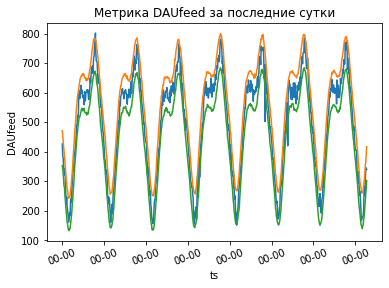

views
[2023-03-03 03:59:15,525] {forecaster.py:921} INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Initial log joint probability = -12.6686
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1787.13    0.00824591       298.032           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1803.95    0.00608103       86.5133           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1807.64   0.000644399       20.0396           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1810.04    0.00886018       60.7514      0.8539      0.8539      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
   

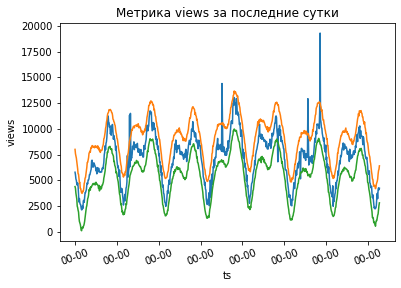

likes
[2023-03-03 03:59:32,687] {forecaster.py:921} INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Initial log joint probability = -10.9295
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1778.37      0.024992       359.471      0.5101           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1793.28    0.00353089        147.83      0.3812           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1799.87     0.0125294       42.1946           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1805.89     0.0113592       56.8979      0.8181      0.8181      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
   

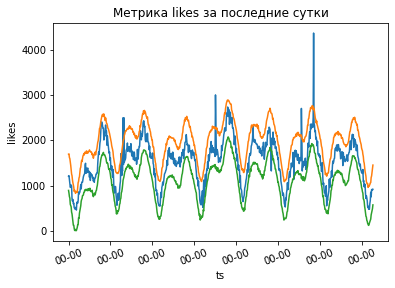

In [13]:
import telegram
import io
import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta, date
import matplotlib.dates as mdates
import pandahouse as ph

from prophet import Prophet

from airflow.decorators import dag, task
from airflow.operators.python import get_current_context

# Подключаемся к боту
my_token = '6093396672:AAHLmoQ6ug3ydEM3n_243YZN9djEdLtjmbM' 
bot = telegram.Bot(token=my_token) # получаем доступ

# Подключение к схеме с данными для выгрузок
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

connection_test = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'test',
                      'user':'student-rw', 
                      'password':'656e2b0c9c'
                     }

# Дефолтные параметры, которые прокидываются в таски
default_args = {
    'owner': 'a-perepelova',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
    'start_date': datetime(2023, 2, 13),
}

# Интервал запуска DAG
schedule_interval = '0 11 * * *'

#@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def perepelova_anomaly_dag(chat_id = 427505265):
    '''
    Каждые 15 минут dag сканирует данные на наличие аномалий и
    в случае проблем отправляет уведомление в ТГ чат. 
    Данные, которые анализируются:
    - активные пользователи в ленте / мессенджере,
    - просмотры,
    - лайки,
    - CTR,
    - количество отправленных сообщений
    '''

    # Выгружаем данные
    #@task
    def extract():
        query = '''
                with feeds as
                (SELECT 
                        toStartOfFifteenMinutes(time) as ts,
                        toDate(time) as dt,
                        formatDateTime(ts,'%R') as hm,
                        count(distinct user_id) as DAUfeed,
                        countIf(user_id, action = 'view') as views,
                        countIf(user_id, action = 'like') as likes,
                        round(likes*100/views,2) as CTR
                    FROM 
                        simulator_20230120.feed_actions  
                    where  toStartOfFifteenMinutes(time)!= toStartOfFifteenMinutes(now())
                    and time >= today() - 7
                    group by ts, dt, hm
                    order by ts),
                msg as
                (SELECT
                        toStartOfFifteenMinutes(time) as ts,
                        toDate(time) as dt,
                        formatDateTime(ts,'%R') as hm,
                        count(distinct user_id) as DAUmsg,
                        count(user_id) as messages
                    FROM 
                        simulator_20230120.message_actions
                    where toStartOfFifteenMinutes(time)!= toStartOfFifteenMinutes(now())
                    and time >= today() - 7
                    group by ts, dt, hm
                    order by ts)
                SELECT feeds.ts,
                        feeds.dt,
                        feeds.hm,
                        DAUfeed,
                        DAUmsg,
                        views,
                        likes,
                        CTR,
                        messages
                from feeds
                left join msg  using(ts,dt,hm)
                
                '''
        df = ph.read_clickhouse(query, connection=connection)
        return df
        
        
    #@task
    def extrac_old_anomalies(connection=connection_test):
        '''
        Функция выгружает известные аномалии, 
        чтобы исключить их в последствии из обучающей выборки
        '''
        query = '''
        SELECT *
        FROM test.a_perepelova_anomaly
        WHERE dt >= today() - 30
        '''
        anomalies = ph.read_clickhouse(query, connection=connection)
        return anomalies
    
    
    # Функция проверки на аномалии с помощью prophet предсказания
    #@task
    def anomaly_check(df, metric,anomalies, n=5, a=4):
        '''
        Используем метод предсказания временного ряда: 
        с помощью Prophet предсказываем значение на последнюю пятиминутку и
        для этого строим доверительный интервал. 
        Отправляем сообщение об анлмалии, если:
         - точка не попадает в доверительный интервал
         - точка отличается от предыдущей более чем на 10% (чтобы убрать мелкие отклонения)
        '''
        
         # Уберем известные аномалии
        df = df[~(df['ts'].isin(anomalies[anomalies['metric']==metric]['dt']))][['ts','dt',metric]].copy()
        
        # Создадим тренировочный датасет
        ph_df = df[['ts',metric]].rename(columns={'ts':'ds',metric:'y'})
        train = ph_df[:-1]
        
        #Запустим Prophet  с заранее подобранными кросс-валидацией параметрами
        params = pd.read_csv('params.csv', sep=';')
        m = Prophet(weekly_seasonality=False,
           seasonality_prior_scale = params[params['metric']==metric]['seasonality_prior_scale'].values[0],
           changepoint_prior_scale = params[params['metric']==metric]['changepoint_prior_scale'].values[0],
           interval_width=0.99)
        m.add_country_holidays(country_name='RU')
        m.fit(train)
        future = m.make_future_dataframe(periods=1, freq='15 min')
        forecast = m.predict(future)
        result = forecast.merge(ph_df, on='ds')
        
        # Выделяем аномалии
        result['e'] = result['y'] - result['yhat']
        result['p'] = 100*result['e']/result['y']
        new_anomaly = result[((result['y']>result['yhat_upper'])|(result['y']<result['yhat_lower']))&
                    (result['p']>10)][['ds','y']]
        new_anomaly['metric'] = metric
        new_anomaly.columns = ['dt','value','metric']
       
        new_anomaly = new_anomaly[~new_anomaly['dt'].isin(anomalies['dt'])]
        if len(new_anomaly)>0:
            load_new_anomalies(new_anomaly)
        
        result.rename(columns={'y':metric,
                              'yhat_upper':'upper',
                              'yhat_lower':'lower',
                              'ds':'ts'},inplace=True)
        
        return (new_anomaly, result[['ts',metric,'upper','lower']])
    
    # Отправка сообщения в ТГ в случае нахождения аномалий
    #@task
    def load_new_anomalies(new_anomaly):
        ph.to_clickhouse(new_anomaly,
                 table='a_perepelova_anomaly',
                 index=False,
                 connection=connection_test)
        print('New anomalies loaded')
    
    def send_alert(df,anomalies, chat_id = 427505265):
        metric_list = ['DAUfeed','views','likes']
        tm = df.ts.iloc[-1].strftime('%y-%m-%d')
        palette ={"upper": "tab:green", "lower": "tab:green"}
        
        for metric in metric_list:
            print(metric)
            data = df[['ts','dt','hm',metric]].copy()
            (new_anomaly, df_metric) = anomaly_check(data, metric, anomalies)
            if True:#len(new_anomaly[new_anomaly['dt']==tm])>0: 
                diff = round((df_metric[metric].iloc[-1]/df_metric[metric].iloc[-2]-1)*100,2)
                msg = f''' 
⚠️Метрика *{re.escape(metric)}* за *{re.escape(tm)}*
Текущее значение {df_metric[metric].iloc[-1]}
Отклонение более {re.escape(diff.astype('str'))}%
Ссылка на дашборд: [Лента\-оперативные данные](https://superset.lab.karpov.courses/superset/dashboard/2655/)
                '''
                print(msg)
                bot.sendMessage(chat_id = chat_id, text=msg, parse_mode='MarkdownV2')
                
                # дополним таблицу аномалий
                ph.to_clickhouse(new_anomaly,
                 table='a_perepelova_anomaly',
                 index=False,
                 connection=connection_test)
            
                ax = sns.lineplot(data = df_metric, x='ts', y=metric)
                ax = sns.lineplot(data = df_metric, x='ts', y='upper')
                ax = sns.lineplot(data = df_metric, x='ts', y='lower')
                ax = sns.scatterplot(data = new_anomaly, x='dt', y='value',
                                     palette=['red'ccccbdgckfdklucrgbnubftcbkgnjerjkgrnegrcirueccccbdgckfdkdrdvigkgcvfcjckikjknhjrhlvikrhdd], legend = False)
                plt.title(f'Метрика {metric} за последние сутки')
                # Define the date format
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%H-%M'))
                plt.xticks(rotation=20)

                # Сохраняем в буфер
                plot_object = io.BytesIO()
                plt.savefig(plot_object)
                plot_object.seek(0)
                plot_object.name = f'{metric}_plot.png'
                plt.show()
                plt.close()
                bot.sendPhoto(chat_id=chat_id, photo=plot_object)
                
        return new_anomaly
        
    df = extract()
    anomalies = extrac_old_anomalies()
    new_anomaly = send_alert(df,anomalies)
    return df, new_anomaly


df, new_anomaly = perepelova_anomaly_dag() 